# Part 2: Training  
In this part we will show how using MLRun's **Feature Store** we can easily define a **Feature Vector** and create the dataset we need to run our training process.  

We will see how to:
- Combine multiple data sources to a single Feature Vector
- Create training dataset
- Create a model using an MLRun Hub function

## Environment Setup

Since our work is done in a this project scope, we will first want to define the project itself for all our MLRun work in this notebook.

In [1]:
import mlrun
import os

project, _ = mlrun.set_environment(project='fraud-demo', user_project=True)
# location of the output data files
data_path = os.path.abspath('data/')

In [2]:
mlrun_project = mlrun.new_project(project)

## Create Feature Vector  
In this section we will create our Feature Vector.  
The Feature vector will have a `name` so we can reference to it later via the UI or our serving function, and a list of `features` from the available FeatureSets.  We can add a feature from a feature set by adding `<FeatureSet>.<Feature>` to the list, or add `<FeatureSet>.*` to add all the FeatureSet's available features.  
The `Label` is added explicitely from the available features so we will not look for it when serving in real-time (since it won't be available).

By default, the first FeatureSet in the feature list will act as the spine. meaning that all the other features will be joined to it.  
So for example, in this instance we use the early_sense sensor data as our spine, so for each early_sense event we will create produce a row in the resulted Feature Vector.

In [3]:
# Import MLRun's Feature Store
import mlrun.feature_store as fs

# Define the featuer vector's name for future reference
feature_vector_name = 'transactions-fraud'

# Define the list of features in the feature vector
features = ['transactions.amount_max_2h', 
            'transactions.amount_sum_2h', 
            'transactions.amount_count_2h',
            'transactions.amount_avg_2h', 
            'transactions.amount_max_12h', 
            'transactions.amount_sum_12h',
            'transactions.amount_count_12h', 
            'transactions.amount_avg_12h', 
            'transactions.amount_max_24h',
            'transactions.amount_sum_24h', 
            'transactions.amount_count_24h', 
            'transactions.amount_avg_24h',
            'transactions.step', 
            'transactions.amount', 
            'transactions.timestamp_hour',
            'transactions.timestamp_day_of_week',
            'events.*',
            'parties.age_mapped',
            'parties.gender_F',
            'parties.gender_M']

# Define the feature vector
fv = fs.FeatureVector(feature_vector_name, 
                      features, 
                      label_feature="labels.label",
                      description='Predict if the transaction is fraud ')

# Save the feature vector in the Feature Store
# fv_tag = 'latest' # default system tag
fv.save()

## Produce training dataset as parquet

In [4]:
# Import the Parquet Target so we can directly save our dataset as a file
from mlrun.datastore.targets import ParquetTarget

# Get offline feature vector
# will return a pandas dataframe and save the dataset to parquet so a 
# training job could train on it
dataset = fs.get_offline_features(feature_vector_name, target=ParquetTarget())

# # View dataset example
df = dataset.to_dataframe()
df.tail()

> 2021-06-13 12:30:59,716 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/fraud-demo-orz/FeatureStore/transactions-fraud/parquet/vectors/transactions-fraud-latest.parquet', 'status': 'ready', 'updated': '2021-06-13T12:30:59.716565+00:00', 'size': 16143366}


,amount_max_2h,amount_sum_2h,amount_count_2h,amount_avg_2h,amount_max_12h,amount_sum_12h,amount_count_12h,amount_avg_12h,amount_max_24h,amount_sum_24h,...,amount,timestamp_hour,timestamp_day_of_week,event_details_change,event_login,event_password_change,age_mapped,gender_F,gender_M,label
2774245,52.6,88.88,2.0,44.44,52.6,88.88,2.0,44.44,52.6,150.36,...,36.28,10,6,1.0,0.0,0.0,2,1,0,0
2774246,52.6,88.88,2.0,44.44,52.6,88.88,2.0,44.44,52.6,150.36,...,36.28,10,6,1.0,0.0,0.0,2,1,0,0
2774247,52.6,88.88,2.0,44.44,52.6,88.88,2.0,44.44,52.6,150.36,...,36.28,10,6,1.0,0.0,0.0,2,1,0,0
2774248,52.6,88.88,2.0,44.44,52.6,88.88,2.0,44.44,52.6,150.36,...,36.28,10,6,1.0,0.0,0.0,2,1,0,0
2774249,52.6,88.88,2.0,44.44,52.6,88.88,2.0,44.44,52.6,150.36,...,36.28,10,6,1.0,0.0,0.0,2,1,0,0


In [5]:
df.columns

Index(['amount_max_2h', 'amount_sum_2h', 'amount_count_2h', 'amount_avg_2h',
       'amount_max_12h', 'amount_sum_12h', 'amount_count_12h',
       'amount_avg_12h', 'amount_max_24h', 'amount_sum_24h',
       'amount_count_24h', 'amount_avg_24h', 'step', 'amount',
       'timestamp_hour', 'timestamp_day_of_week', 'event_details_change',
       'event_login', 'event_password_change', 'age_mapped', 'gender_F',
       'gender_M', 'label'],
      dtype='object')

## Run baseline training

In [6]:
from mlrun.platforms import auto_mount

# Import the SKLearn based training function from our functions hub
fn = mlrun.import_function('hub://sklearn-classifier').apply(auto_mount())

> 2021-06-13 12:31:00,188 [info] starting run training uid=1456492a79dd442496ff03cb8f9f12ba DB=http://mlrun-api:8080
> 2021-06-13 12:44:55,791 [info] best iteration=1, used criteria max.accuracy


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fraud-demo-orz,...8f9f12ba,0,Jun 13 12:31:00,completed,training,v3io_user=orzkind=owner=orz,dataset,label_column=label,best_iteration=1accuracy=0.9999666993198336test-error=3.3300680166392395e-05rocauc=0.9995472424668121brier_score=3.138866611350536e-05f1-score=0.9981894990947496precision_score=0.9990939293264874recall_score=0.9972867048537836,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1456492a79dd442496ff03cb8f9f12ba --project fraud-demo-orz , !mlrun logs 1456492a79dd442496ff03cb8f9f12ba --project fraud-demo-orz
> 2021-06-13 12:44:56,302 [info] run executed, status=completed


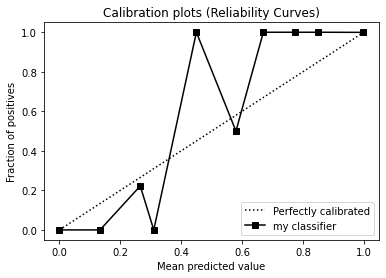

<Figure size 432x288 with 0 Axes>

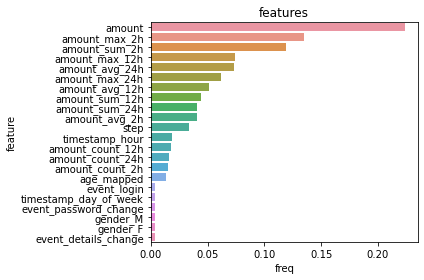

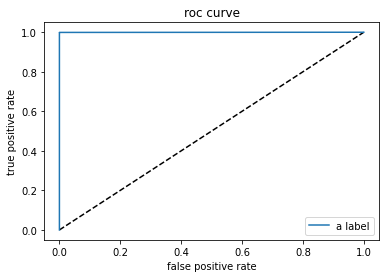

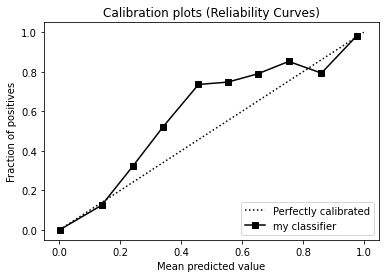

<Figure size 432x288 with 0 Axes>

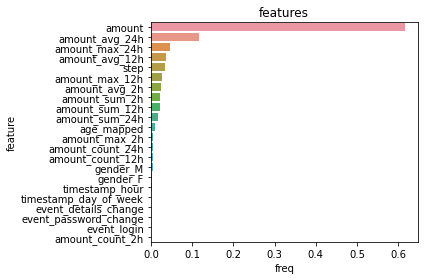

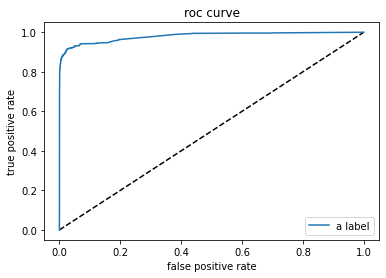

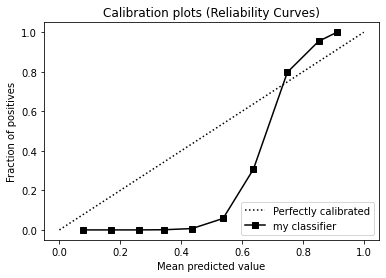

<Figure size 432x288 with 0 Axes>

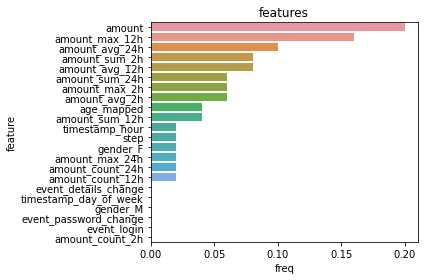

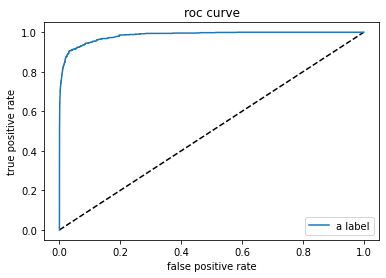

In [7]:
# Prepare the parameters list for the training function
# We define 3 different models to test on our dataset
model_list = {"model_name": ['transaction_fraud_rf', 'transaction_fraud_xgboost', 'transaction_fraud_adaboost'],
              "model_pkg_class": ['sklearn.ensemble.RandomForestClassifier',
                                  'sklearn.ensemble.GradientBoostingClassifier',
                                  'sklearn.ensemble.AdaBoostClassifier']}

# Define the training task, including our feature vector, label and hyperparams definitions
task = mlrun.new_task('training', 
                      inputs={'dataset': f'store://feature-vectors/fraud-demo-orz/transactions-fraud:latest'},
                      params={'label_column': 'label'}
                     )
task.with_hyper_params(model_list, strategy='list', selector='max.accuracy')

# Run the function 
fn.spec.image = 'mlrun/ml-models'
run = fn.run(task, local=True)

## Perform feature selection process on a sample of the dataset

As part of our data science process we will try and reduce the training dataset's size to get rid of bad or unuseful features and save computation time.

We will use our ready-made feature selection function from our hub [`hub://feature_selection`](https://github.com/mlrun/functions/blob/development/feature_selection/feature_selection.ipynb) to select the best features to keep on a sample from our dataset and run the function on that.


### Create a sample dataset 

In [8]:
import pandas as pd

# Configurate the sample dataset
sample_size = 100000
positive_sample_ratio = 0.5

# Calculate the number of positive and negative samples we need to sample
# from the dataset according to our sample size and positive samples ratio
positives_in_sample = df.dropna()[df.label == 1].label.value_counts().values[0]
positive_samples = int(positives_in_sample*positive_sample_ratio)
negative_samples = sample_size - positive_samples

# Sample the actual positive and negative samples from the DF
# into the samples dataset
positives = df.dropna()[df.label == 1].sample(positive_samples)
negatives = df.dropna()[df.label == 0].sample(negative_samples)
sample = pd.concat([positives, negatives])

# Perform adjustments
sample['age_mapped'] = sample['age_mapped'].astype(int)

# Log the dataset as a project artifact
# this will both save the file in the project's artifact path and
# also create a `store://` reference for the dataset
mlrun_project.log_dataset(key='feature_selection_sample',
                          df=sample,
                          format='parquet')

# Show the registered dataitem sample
feature_selection_sample_reference = f'store://{project}/feature_selection_sample'
mlrun.get_dataitem(feature_selection_sample_reference).as_df().head()

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


,amount_max_2h,amount_sum_2h,amount_count_2h,amount_avg_2h,amount_max_12h,amount_sum_12h,amount_count_12h,amount_avg_12h,amount_max_24h,amount_sum_24h,...,amount,timestamp_hour,timestamp_day_of_week,event_details_change,event_login,event_password_change,age_mapped,gender_F,gender_M,label
1601838,155.95,167.44,2.0,20.85,155.95,223.32,4.0,62.763333,155.95,223.32,...,155.95,14,5,0.0,1.0,0.0,3,1,0,1
2396622,137.31,137.31,1.0,3563.64,434.04,590.56,4.0,1034.887500,434.04,659.85,...,137.31,4,6,0.0,1.0,0.0,3,0,1,1
1247149,101.43,101.43,1.0,7.12,101.43,180.71,3.0,41.584000,101.43,229.75,...,101.43,8,5,0.0,1.0,0.0,5,1,0,1
2084889,124.41,124.41,1.0,124.41,124.41,124.41,1.0,124.410000,124.41,124.41,...,124.41,23,5,0.0,1.0,0.0,6,0,1,1
1812738,292.22,292.22,1.0,292.22,464.94,757.16,2.0,378.580000,558.94,1504.76,...,292.22,18,5,0.0,0.0,1.0,4,1,0,1


### Calculate the k for the feature selection

In [9]:
import numpy as np

# Configurations
k_columns_factor = 0.3

# Calculate the k
feature_selection_k = int(len(sample.columns)*k_columns_factor)
feature_selection_k

6

### Perform feature selection

In [10]:
from mlrun import NewTask

feature_selection_fn = mlrun.import_function('hub://feature_selection')
feature_selection_fn.apply(auto_mount())

task = NewTask(params={'k': feature_selection_k,
                       'min_votes': 0.3,
                       'label_column': 'label'},
               inputs={'df_artifact': feature_selection_sample_reference},
               name='feature_extraction',
               handler='feature_selection')

feature_selection_run = feature_selection_fn.run(task)

> 2021-06-13 12:45:01,320 [info] starting run feature_extraction uid=2c3441ff2b434bde8c9f99fddab31473 DB=http://mlrun-api:8080
> 2021-06-13 12:45:01,469 [info] Job is running in the background, pod: feature-extraction-kpgzz
> 2021-06-13 12:45:07,674 [info] input dataset /v3io/projects/fraud-demo-orz/artifacts/feature_selection_sample.parquet
> 2021-06-13 12:46:10,992 [info] votes needed to be selected: 2
> 2021-06-13 12:46:11,160 [info] run executed, status=completed
Pass k=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fraud-demo-orz,...dab31473,0,Jun 13 12:45:07,completed,feature_extraction,v3io_user=orzkind=jobowner=orzhost=feature-extraction-kpgzz,df_artifact,k=6min_votes=0.3label_column=label,,f_classifmutual_info_classifchi2f_regressionLinearSVCLogisticRegressionExtraTreesClassifierfeature_scoresmax_scaled_scores_feature_scoresselected_features_countselected_features


to track results use .show() or .logs() or in CLI: 
!mlrun get run 2c3441ff2b434bde8c9f99fddab31473 --project fraud-demo-orz , !mlrun logs 2c3441ff2b434bde8c9f99fddab31473 --project fraud-demo-orz
> 2021-06-13 12:46:20,141 [info] run executed, status=completed


In [11]:
mlrun.get_dataitem(feature_selection_run.output('selected_features_count')).as_df().sort_values(by='num_votes')

,f_classif,mutual_info_classif,chi2,f_regression,LinearSVC,LogisticRegression,ExtraTreesClassifier,num_votes
gender_M,0,0,0,0,0,0,0,0
amount_avg_2h,0,0,0,0,0,0,0,0
step,0,0,0,0,0,0,0,0
gender_F,0,0,0,0,0,0,0,0
age_mapped,0,0,0,0,0,1,0,1
event_password_change,0,0,0,0,1,0,0,1
event_login,0,0,0,0,1,0,0,1
event_details_change,0,0,0,0,1,0,0,1
timestamp_day_of_week,0,0,0,0,0,1,0,1
timestamp_hour,0,0,0,0,0,1,0,1


In [12]:
selected_features_sample = mlrun.get_dataitem(feature_selection_run.output('selected_features')).as_df()
selected_features = list(selected_features_sample.columns)
selected_features

['amount_max_2h',
 'amount_sum_2h',
 'amount_max_12h',
 'amount_sum_12h',
 'amount_max_24h',
 'amount_sum_24h',
 'amount_avg_24h',
 'amount',
 'label']

### Create a v2 feature vector

In [13]:
features = ['transactions.amount_sum_2h',
            'transactions.amount_max_2h',
            'transactions.amount_sum_12h',
            'transactions.amount_max_24h',
            'transactions.amount_sum_24h', 
            'transactions.amount_avg_24h',
            'transactions.amount']
 
# Define the feature vector
fv = fs.FeatureVector(feature_vector_name, 
                      features, 
                      label_feature="labels.label",
                      description='Predict if the transaction is fraud ')

# Save the feature vector in the Feature Store
fv_tag = 'v1'
fv.save(tag=fv_tag)

In [14]:
from mlrun.datastore.targets import CSVTarget

# Get offline feature vector
# will return a pandas dataframe and save the dataset to parquet so a 
# training job could train on it
dataset = fs.get_offline_features(f'{feature_vector_name}:{fv_tag}', target=ParquetTarget())

# # View dataset example
df = dataset.to_dataframe()
df.tail()

> 2021-06-13 12:46:20,712 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/fraud-demo-orz/FeatureStore/transactions-fraud/parquet/vectors/transactions-fraud-v1.parquet', 'status': 'ready', 'updated': '2021-06-13T12:46:20.712278+00:00', 'size': 2449946}


,amount_sum_2h,amount_max_2h,amount_sum_12h,amount_max_24h,amount_sum_24h,amount_avg_24h,amount,label
99995,25.09,25.09,56.80,56.02,160.19,32.038000,25.09,0
99996,11.93,11.93,23.93,49.68,73.61,24.536667,11.93,0
99997,30.12,21.30,115.76,51.67,115.76,23.152000,8.82,0
99998,38.10,38.10,267.81,61.48,312.40,31.240000,38.10,0
99999,88.88,52.60,88.88,52.60,150.36,30.072000,36.28,0


### Train ensemble of models

> 2021-06-13 12:46:20,774 [info] starting run training uid=c48947752e24458ab78e5909727ab8a1 DB=http://mlrun-api:8080
> 2021-06-13 12:46:40,957 [info] best iteration=2, used criteria max.accuracy


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fraud-demo-orz,...727ab8a1,0,Jun 13 12:46:20,completed,training,v3io_user=orzkind=owner=orz,dataset,label_column=label,best_iteration=2accuracy=0.9941069809610155test-error=0.0058930190389845875rocauc=0.9695794079550757brier_score=0.005055872484697844f1-score=0.7111111111111111precision_score=0.8135593220338984recall_score=0.631578947368421,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run c48947752e24458ab78e5909727ab8a1 --project fraud-demo-orz , !mlrun logs c48947752e24458ab78e5909727ab8a1 --project fraud-demo-orz
> 2021-06-13 12:46:41,259 [info] run executed, status=completed


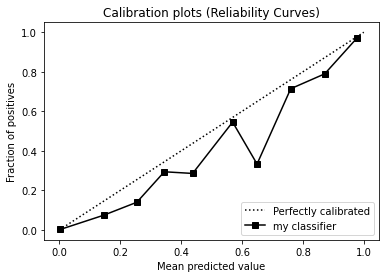

<Figure size 432x288 with 0 Axes>

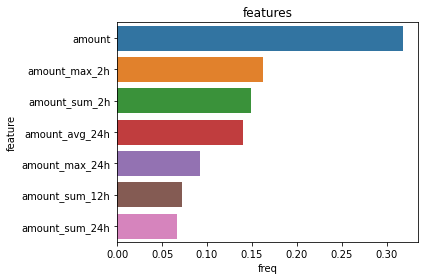

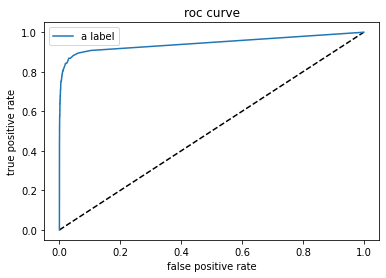

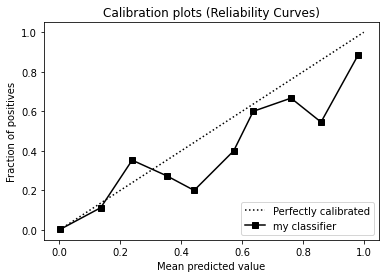

<Figure size 432x288 with 0 Axes>

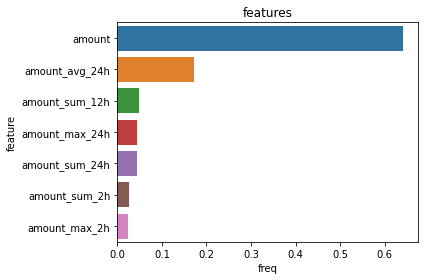

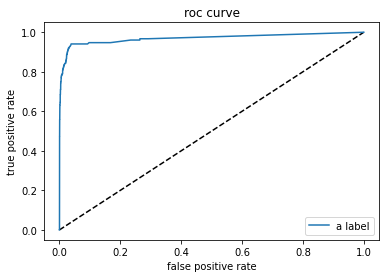

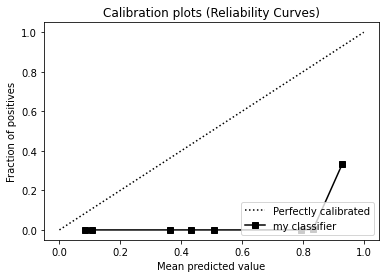

<Figure size 432x288 with 0 Axes>

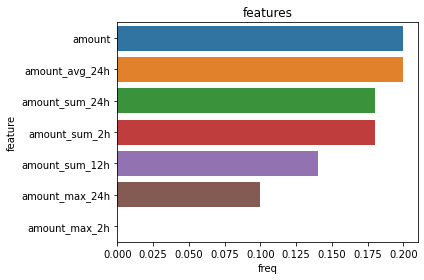

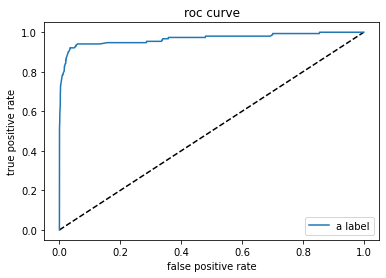

In [15]:
# Define the training task, including our feature vector, label and hyperparams definitions
task = mlrun.new_task('training', 
                      inputs={'dataset': f'store://feature-vectors/{project}/{feature_vector_name}:{fv_tag}'},
                      params={'label_column': 'label'}
                     )
task.with_hyper_params(model_list, strategy='list', selector='max.accuracy')

run = fn.run(task, local=True)

In [16]:
run.outputs

{'best_iteration': 2,
 'accuracy': 0.9941069809610155,
 'test-error': 0.0058930190389845875,
 'rocauc': 0.9695794079550757,
 'brier_score': 0.005055872484697844,
 'f1-score': 0.7111111111111111,
 'precision_score': 0.8135593220338984,
 'recall_score': 0.631578947368421,
 'test_set': 'store://artifacts/fraud-demo-orz/training_test_set:c48947752e24458ab78e5909727ab8a1',
 'probability-calibration': '/v3io/projects/fraud-demo-orz/artifacts/model/plots/2/probability-calibration.html',
 'confusion-matrix': '/v3io/projects/fraud-demo-orz/artifacts/model/plots/2/confusion-matrix.html',
 'feature-importances': '/v3io/projects/fraud-demo-orz/artifacts/model/plots/2/feature-importances.html',
 'precision-recall-binary': '/v3io/projects/fraud-demo-orz/artifacts/model/plots/2/precision-recall-binary.html',
 'roc-binary': '/v3io/projects/fraud-demo-orz/artifacts/model/plots/2/roc-binary.html',
 'model': 'store://artifacts/fraud-demo-orz/training_model:c48947752e24458ab78e5909727ab8a1',
 'iteration_r